In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from models import *
from utils import *
from torchsummary import summary

In [74]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [75]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomGrayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [76]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
print("train data shape: ", trainset.data.shape)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
print("test data shape: ", testset.data.shape)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
train data shape:  (50000, 32, 32, 3)


/ext3/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified
test data shape:  (10000, 32, 32, 3)


In [77]:
class KaggleDataset(Dataset):
    def __init__(self, data_file, label_file, transform=None):
        unpickled_data = unpickle(data_file)
        print()
        self.data = unpickled_data[b'data'].reshape(-1,3,32,32).transpose(0,2,3,1)
        df = pd.read_csv(label_file)
        self.labels = df['label'].values
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        if self.transform:
            x = self.transform(x)
        x = torch.tensor(x)
        y = torch.tensor(self.labels[idx])
        return x,y

In [78]:
kaggle_testset = KaggleDataset('cifar_test_nolabels.pkl', 'test.csv',transform_test)

In [79]:
kaggle_testloader = torch.utils.data.DataLoader(
    kaggle_testset, batch_size=100, shuffle=False)

In [127]:
net = ResNetWide()
# net = RestNetWide()
# net = RestNetDeep()
net = torch.nn.DataParallel(net)
criterion = nn.CrossEntropyLoss()

In [129]:
path = 'new_saved_results/ResNetWide_batch_size_128_epochs_200_CosineAnnealingLR_ASGD_data_augmentation'
# path = 'saved_results/ResNet18_batch_size_128_epochs_200_CosineAnnealingLR_SGD_data_augmentation'
checkpoint = torch.load(f'{path}/ckpt.pth')
net.load_state_dict(checkpoint['net'])
best_acc = checkpoint['acc']

In [130]:
best_acc

93.66

In [131]:
def test(epoch,dataloader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    predicted_labels = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            predicted_labels.append(predicted.detach().cpu().numpy())
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    # acc = 100.*correct/total
    # if acc > best_acc:
    #     print('Saving..')
    #     state = {
    #         'net': net.state_dict(),
    #         'acc': acc,
    #         'epoch': epoch,
    #     }
    #     # if not os.path.isdir(f'checkpoint'):
    #     #     os.mkdir('checkpoint')
    #     torch.save(state, f'{saved_path}/ckpt.pth')
    #     best_acc = acc
    return test_loss/(batch_idx+1), correct/total, best_acc, predicted_labels
device = 'cuda'
# schedul
test_loss, test_acc, test_best_acc, predicted_labels = test(1,testloader)


 [================================================================>]  Step: 13ms | Tot: 2s847ms | Loss: 0.300 | Acc: 93.660% (9366/10000)                                                              100/100 =====>..........................................................]  Step: 32ms | Tot: 282ms | Loss: 0.281 | Acc: 93.545% (1029/1100)                                                                 11/100 =======>.........................................................]  Step: 42ms | Tot: 325ms | Loss: 0.293 | Acc: 93.417% (1121/1200)                                                                 12/100 ========>........................................................]  Step: 26ms | Tot: 371ms | Loss: 0.290 | Acc: 93.643% (1311/1400)                                                                 14/100 ===================>.............................................]  Step: 44ms | Tot: 860ms | Loss: 0.323 | Acc: 93.484% (2898/3100)                                                  

In [132]:
kaggle_loss, kaggle_acc,kaggle_best_acc, predicted_labels = test(1,kaggle_testloader)

/state/partition1/job-45222041/ipykernel_3319223/3821771668.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


 [================================================================>]  Step: 22ms | Tot: 2s245ms | Loss: 2.199 | Acc: 76.340% (7634/10000)                                                              100/100 


In [117]:
labels = np.array(predicted_labels).ravel()
df = pd.DataFrame(labels,columns=['Labels'])
df.index.name = 'ID'
df

,Labels
ID,
0,8
1,8
2,8
3,8
4,8
...,...
9995,5
9996,5
9997,5


In [119]:
df.to_csv('kaggle_results_wide1_aug_SGD.csv')

In [160]:
df.loc[df['IDs'] == f'{idx}.jpg']

,IDs,Predict_Labels
9375,138.jpg,0


In [14]:
df = df.rename({'IDs':'ID','Predict_Labels':'Labels'},axis='columns')
df

,ID,Labels
1704,0,8
8269,1,8
1434,2,8
9661,3,8
753,4,2
...,...,...
1228,9995,5
5856,9996,5
8827,9997,5
4696,9998,5


In [11]:
predicted_labels = []
for batch_idx, (data, targets) in enumerate(testloader):
    # print(batch_idx)
    # print(data[0])
    # plt.figure()
    # plt.imshow(data[5].permute(1,2,0))
    # plt.show()
    outputs = net(data)
    _, predictions = outputs.max(1)
    # predicted_labels[batch_idx*500:(batch_idx+1)*500] = predictions.detach().cpu().numpy()
    predicted_labels.append(predictions.detach().cpu().numpy())

/ext3/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
df = pd.read_csv('data.csv')
df['IDs'] = df.apply(lambda row: int(row['IDs'][:-4]), axis=1)
df = df.sort_values(by=['IDs'])

In [36]:
labels = np.array(predicted_labels).ravel()

In [37]:
labels

array([8, 8, 8, ..., 3, 5, 8])

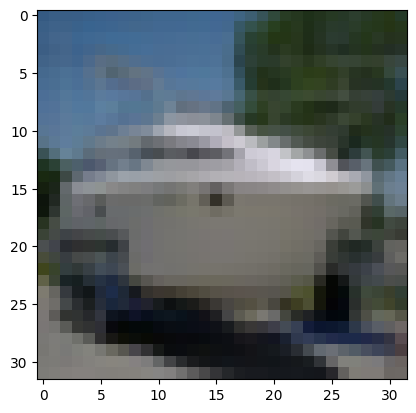

In [26]:
plt.imshow(dataset[20][0])